In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

### Установка необходимых пакетов / загрузка библиотек

> Successfully installed xgboost-1.6.1

> Successfully installed lightgbm-3.3.2

> Successfully installed catboost-1.0.6

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from scipy.stats import mannwhitneyu

# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier as catb
import xgboost as xgb, lightgbm as lgbm

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Подготовка функций для работы с данными

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title = 'Importance of features'
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
# присвоение значений из большего класса меньшему
def join_minor_class_to_major(feature_name, minor_name, major_name, df):
    df.loc[df[feature_name] == minor_name, feature_name] = major_name

In [10]:
def find_null_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        if pct_missing > 0:
            print('{} ~ {}%'.format(col, round(pct_missing*100)))

In [11]:
def find_outer_boundaries(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)

    iqr = q3 - q1
    upper_bound = q3 + 3 * iqr
    lower_bound = q1 - 3 * iqr
    
    return {
        'upper_bound': upper_bound,
        'lower_bound': lower_bound,
        'iqr': iqr
    }

In [12]:
def f_plot_distribution(df, col, bins_val=50, logy=False, logx=False):
    col_mean = round(df[col].mean(), 2)
    col_median = df[col].median()
    col_mode = df[col].mode()[0]
    
    col_q025 = df[col].quantile(0.025)
    col_q975 = df[col].quantile(0.975)
    col_q005 = df[col].quantile(0.005)
    col_q995 = df[col].quantile(0.995)

    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
        
    
    
    plt.figure(figsize = (12, 6))

    sns.distplot(df[col], bins=bins_val)

    y = np.linspace(0, 0.0000005, 10)
    
    plt.plot([col_mean] * 10 , y, label='mean',  linewidth=3)
    plt.plot([col_median] * 10, y, label='median',  linewidth=3)
    plt.plot([col_mode] * 10, y, label='mode', linewidth=3)

    plt.title('Distribution of ' + col)
    plt.legend(loc='upper left')
    plt.show()
    print(f"\tMean= {col_mean}    Median= {col_median}    Mode= {col_mode}")
    print(f"\tq025= {col_q025:.2f}  \tq005= {col_q005:.2f}")
    print(f"\tq975= {col_q975:.2f}  \tq995= {col_q995:.2f}")    
    return

In [13]:
def show_kde_plot(train, test, feature):
    figsize = (6, 3)
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[feature], shade=True, label='train', color='r')
    sns.kdeplot(test[feature], shade=True, label='test', color='g')
    print(feature)
    print(mannwhitneyu(train[feature], test[feature]))
    plt.legend()
    plt.title(feature)
    plt.show()

### Загрузка данных (EDA)

In [14]:
# Input:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

# Output:
SAMPLE_SUBMIT_PATH = './BBurtsev_predictions.csv'

# Usefull vars:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = []
NUM_FEATURE_NAMES = []
CAT_FEATURE_NAMES = []

#### Данные обучения:

In [15]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = train_df.reset_index(drop=True)
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [16]:
train_df.shape

(7500, 17)

**Описание датасета:**

1. **Home Ownership** - вид домовладения   <font color='green' size='4'>&#10003;</font>
2. **Annual Income** - годовой доход &#10003;
3. **Years in current job** - количество лет на текущем месте работы   <font color='green' size='4'>&#10003;</font>
4. **Tax Liens** - налоговые обременения   <font color='green' size='4'>&#10003;</font>
5. **Number of Open Accounts** - количество открытых счетов   <font color='green' size='4'>&#10003;</font>
6. **Years of Credit History** - количество лет кредитной истории   <font color='green' size='4'>&#10003;</font>
7. **Maximum Open Credit** - максимальный размер открытого кредита   <font color='green' size='4'>&#10003;</font>
8. **Number of Credit Problems** - количество проблем с кредитом   <font color='green' size='4'>&#10003;</font>
9. **Months since last delinquent** - количество месяцев с последней просрочки платежа  <font color='green' size='4'>&#10003;</font>
10. **Bankruptcies** - число банкротств  <font color='green' size='4'>&#10003;</font>
11. **Purpose** - цель кредита  <font color='green' size='4'>&#10003;</font>
12. **Term** - срок кредита  <font color='green' size='4'>&#10003;</font>
13. **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)  <font color='green' size='4'>&#10003;</font>
14. **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)  <font color='green' size='4'>&#10003;</font>
15. **Monthly Debt** - ежемесячный платёж  <font color='green' size='4'>&#10003;</font>
16. **Credit Score** - индекс кредитоспособности  <font color='green' size='4'>&#10003;</font>

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Целевая переменная:**

- <font color='red'>**Credit Default**</font> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [18]:
# Распределение целевой переменной (нормализованное):
train_df[TARGET_NAME].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

> Доля объектов целевого объекта ~ 28%

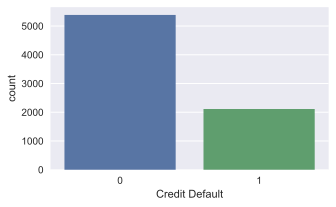

In [19]:
# Визуализация:
plt.figure(figsize=(5, 3))
sns.countplot(x=TARGET_NAME, data=train_df)
plt.show()

#### Данные тестирования:

In [20]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = test_df.reset_index(drop=True)
test_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [21]:
test_df.shape

(2500, 16)

In [22]:
# объединяю категориальные признаки в список + обзор категориальных признаков:
for cat_colname in train_df.select_dtypes(include='object').columns:
    CAT_FEATURE_NAMES.append(cat_colname)
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n\n' + '*' * 100 + '\n')
print(CAT_FEATURE_NAMES)

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation

In [23]:
# объединяю количественные признаки в список:
for num_colname in train_df.select_dtypes(exclude='object').columns:
    if num_colname == TARGET_NAME:
        continue
    NUM_FEATURE_NAMES.append(num_colname)
print(NUM_FEATURE_NAMES)

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']


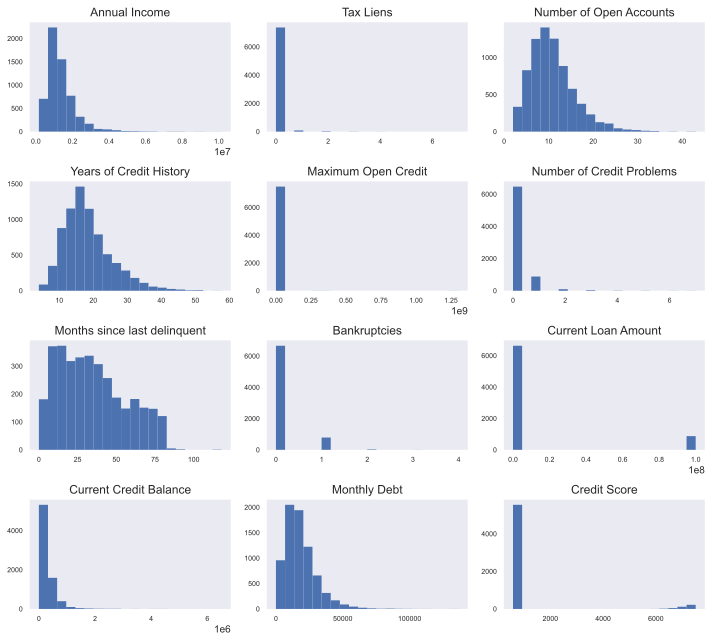

In [24]:
# визуальное отображение количественных фичей:
train_df[NUM_FEATURE_NAMES].hist(figsize=(10, 9), bins=20, grid=False, xlabelsize=7, ylabelsize=7, layout=(4, 3))
plt.tight_layout()
plt.show()

In [25]:
pd.options.display.float_format = '{:,.3f}'.format # запретить exp и отображать float до 3-го знака после запятой
train_df[NUM_FEATURE_NAMES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"5,943.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","3,419.000","7,486.000","7,500.000","7,500.000","7,500.000","5,943.000"
mean,"1,366,391.720",0.030,11.131,18.317,"945,153.727",0.170,34.693,0.117,"11,873,177.445","289,833.235","18,314.454","1,151.087"
std,"845,339.200",0.272,4.909,7.042,"16,026,216.671",0.499,21.689,0.347,"31,926,122.975","317,871.382","11,926.765","1,604.451"
min,"164,597.000",0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"844,341.000",0.000,8.000,13.500,"279,229.500",0.000,16.000,0.000,"180,169.000","114,256.500","10,067.500",711.000
50%,"1,168,386.000",0.000,10.000,17.000,"478,159.000",0.000,32.000,0.000,"309,573.000","209,323.000","16,076.500",731.000
75%,"1,640,137.000",0.000,14.000,21.800,"793,501.500",0.000,50.000,0.000,"519,882.000","360,406.250","23,818.000",743.000
max,"10,149,344.000",7.000,43.000,57.700,"1,304,726,170.000",7.000,118.000,4.000,"99,999,999.000","6,506,797.000","136,679.000","7,510.000"


#### Матрица корреляции

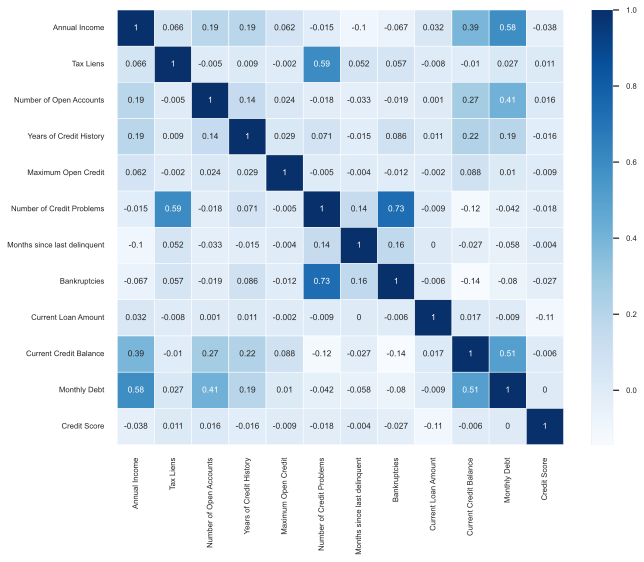

In [26]:
plt.figure(figsize=(10,8))

sns.set(font_scale=0.7)
sns.heatmap(train_df[NUM_FEATURE_NAMES].corr().round(3), color='white', annot=True, linewidth=.5, cmap='Blues')

plt.show()

### <font color='red'>Обработка выбросов</font> 

#### Home Ownership

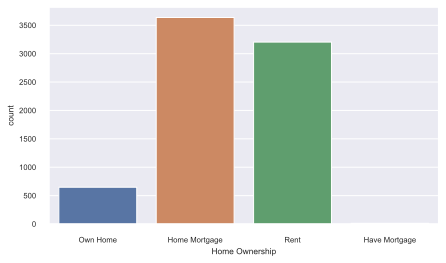

In [27]:
# Home ownership:
plt.figure(figsize=(7,4))

sns.countplot(x='Home Ownership', data=train_df)

plt.show()

In [28]:
# Вхождения значения признака Home Ownership Have Mortgage следует объединить в Home Mortgage
# Они несут одну и ту же информацию по сути, а также признак Have Mortgage крайне редкий
join_minor_class_to_major(feature_name='Home Ownership', minor_name='Have Mortgage', major_name='Home Mortgage', df=train_df)

In [29]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

#### Annual Income

In [30]:
annual_inc = train_df['Annual Income']
annual_inc.describe()

count        5,943.000
mean     1,366,391.720
std        845,339.200
min        164,597.000
25%        844,341.000
50%      1,168,386.000
75%      1,640,137.000
max     10,149,344.000
Name: Annual Income, dtype: float64

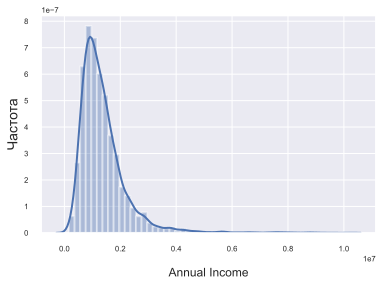

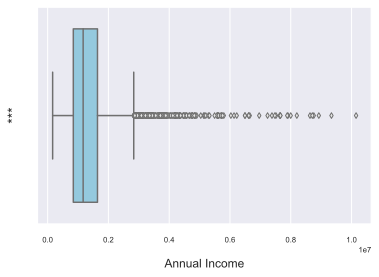

In [31]:
sns.distplot(annual_inc, hist_kws={"edgecolor": 'w', "linewidth": 2}, kde_kws={"linewidth": 2})

plt.ylabel('Частота', fontsize=14)
plt.xlabel('Annual Income', fontsize=12, labelpad=15)

plt.show()

flierprops = dict(markerfacecolor='0.9', markersize=4, linestyle='none')
sns.boxplot(x=annual_inc, flierprops=flierprops, color='skyblue')

plt.ylabel('***', fontsize=14)
plt.xlabel('Annual Income', fontsize=12, labelpad=15)
plt.xscale('linear')

plt.show()

In [32]:
# найдём значительные выбросы
ai_q1 = annual_inc.quantile(0.25)
ai_q3 = annual_inc.quantile(0.75)

ai_iqr = ai_q3 - ai_q1
upper_bound = ai_q3 + 3 * ai_iqr
print(ai_iqr, upper_bound)

mask = annual_inc > upper_bound

795796.0 4027525.0


In [33]:
# заменим все выбросы 'Annual Income' на медиану
ai_median = annual_inc.median()
print(ai_median)
train_df.loc[mask, 'Annual Income'] = ai_median

1168386.0


In [34]:
train_df['Annual Income'].describe()

count       5,943.000
mean    1,299,524.905
std       640,926.518
min       164,597.000
25%       844,341.000
50%     1,168,386.000
75%     1,600,873.500
max     3,997,334.000
Name: Annual Income, dtype: float64

#### Number of open accounts

In [35]:
accounts_num = train_df['Number of Open Accounts']

In [36]:
accounts_num.describe()

count   7,500.000
mean       11.131
std         4.909
min         2.000
25%         8.000
50%        10.000
75%        14.000
max        43.000
Name: Number of Open Accounts, dtype: float64

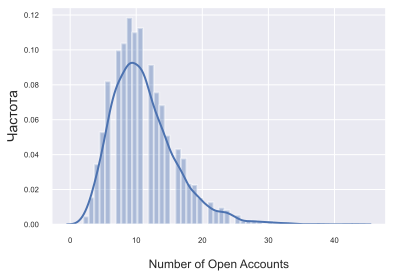

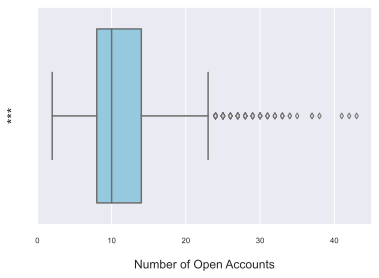

In [37]:
sns.distplot(accounts_num, hist_kws={"edgecolor": 'w', "linewidth": 2}, kde_kws={"linewidth": 2})

plt.ylabel('Частота', fontsize=14)
plt.xlabel('Number of Open Accounts', fontsize=12, labelpad=15)

plt.show()

sns.boxplot(x=accounts_num, flierprops=flierprops, color='skyblue')

plt.ylabel('***', fontsize=14)
plt.xlabel('Number of Open Accounts', fontsize=12, labelpad=15)
plt.xscale('linear')

plt.show()

In [38]:
# найдём значительные выбросы
an_q1 = accounts_num.quantile(0.25)
an_q3 = accounts_num.quantile(0.75)

an_iqr = an_q3 - an_q1
an_upper_bound = an_q3 + 3 * an_iqr
print(an_iqr, an_upper_bound)

mask = accounts_num > an_upper_bound

6.0 32.0


In [39]:
# заменим все выбросы 'Number of Open Accounts' на верхнюю границу
train_df.loc[mask, 'Number of Open Accounts'] = an_upper_bound
accounts_num.describe()

count   7,500.000
mean       11.123
std         4.870
min         2.000
25%         8.000
50%        10.000
75%        14.000
max        32.000
Name: Number of Open Accounts, dtype: float64

#### Years of Credit History: ничего не делать

In [40]:
credit_history = train_df['Years of Credit History']
credit_history.describe()

count   7,500.000
mean       18.317
std         7.042
min         4.000
25%        13.500
50%        17.000
75%        21.800
max        57.700
Name: Years of Credit History, dtype: float64

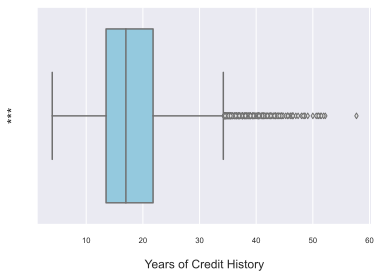

In [41]:
sns.boxplot(x=credit_history, flierprops=flierprops, color='skyblue')

plt.ylabel('***', fontsize=14)
plt.xlabel('Years of Credit History', fontsize=12, labelpad=15)
plt.xscale('linear')

plt.show()

#### Current Loan Amount

In [42]:
crn_loan_amount = train_df['Current Loan Amount']
crn_loan_amount.describe()

count        7,500.000
mean    11,873,177.445
std     31,926,122.975
min         11,242.000
25%        180,169.000
50%        309,573.000
75%        519,882.000
max     99,999,999.000
Name: Current Loan Amount, dtype: float64

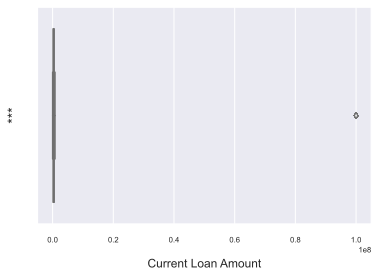

In [43]:
# на графике виден явный выброс: это аномалия - удаляем
sns.boxplot(x=crn_loan_amount, flierprops=flierprops, color='skyblue')

plt.ylabel('***', fontsize=14)
plt.xlabel('Current Loan Amount', fontsize=12, labelpad=15)
plt.xscale('linear')

plt.show()

In [44]:
crn_loan_boundaries = find_outer_boundaries(crn_loan_amount)
crn_loan_boundaries

{'upper_bound': 1539021.0, 'lower_bound': -838970.0, 'iqr': 339713.0}

In [45]:
crn_loan_mask = crn_loan_amount > crn_loan_boundaries['upper_bound']
train_df.loc[crn_loan_mask, 'Current Loan Amount'].value_counts()

99,999,999.000    870
Name: Current Loan Amount, dtype: int64

In [46]:
# заменим медианой
crn_loan_median = crn_loan_amount.median()
print(crn_loan_median)
train_df.loc[crn_loan_mask, 'Current Loan Amount'] = crn_loan_median

309573.0


In [47]:
crn_loan_amount.describe()

count     7,500.000
mean    309,088.029
std     171,393.740
min      11,242.000
25%     180,169.000
50%     309,567.500
75%     396,929.500
max     789,030.000
Name: Current Loan Amount, dtype: float64

#### Maximum Open Credit

> максимальный открытый кредит не может превышать максимум текущей суммы кредита, поэтому за верхнюю границу берём максимальное значение текущей суммы кредита

In [48]:
max_credit = crn_loan_amount.max()

max_open_credit = train_df['Maximum Open Credit']
max_open_credit.describe()

count           7,500.000
mean          945,153.727
std        16,026,216.671
min                 0.000
25%           279,229.500
50%           478,159.000
75%           793,501.500
max     1,304,726,170.000
Name: Maximum Open Credit, dtype: float64

In [49]:
# всё что выше, считаем выбросами и заменяем медианой
oc_mask = max_open_credit > max_credit
open_credit_median = max_open_credit.median()
train_df.loc[oc_mask, 'Maximum Open Credit'] = open_credit_median
max_open_credit.describe()

count     7,500.000
mean    410,568.998
std     172,773.105
min           0.000
25%     279,229.500
50%     478,153.500
75%     478,159.000
max     788,194.000
Name: Maximum Open Credit, dtype: float64

#### Purpose

In [50]:
purpose = train_df['Purpose']
purpose.value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

<AxesSubplot:xlabel='Purpose', ylabel='count'>

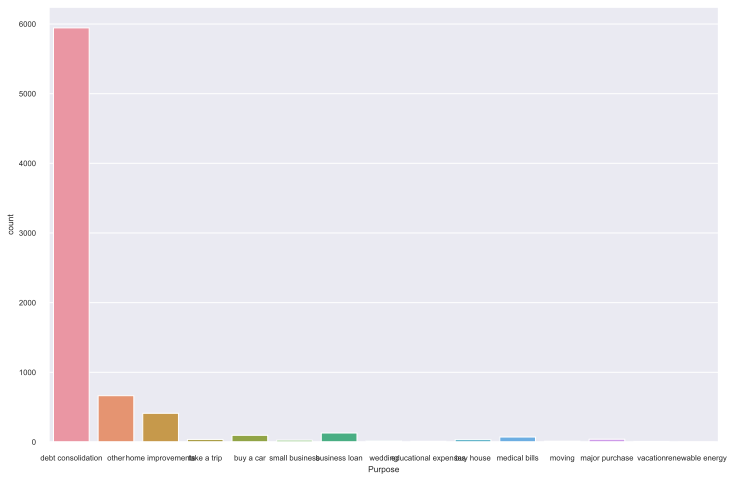

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(ax=ax, x='Purpose', data=train_df)

In [52]:
# по цели разделил на 3 категории (для бизнеса, погашение долга и остальное)
purpose_dict = {
    'debt consolidation': 0,
    'other': 1,
    'home improvements': 1,
    'business loan': 2,
    'buy a car': 1,
    'medical bills': 1,
    'major purchase': 1,
    'take a trip': 1,
    'buy house': 1,
    'small business': 2,
    'wedding': 1,
    'moving': 1,
    'educational expenses': 1,
    'vacation': 1,
    'renewable energy': 1
}

train_df.replace({'Purpose': purpose_dict}, inplace=True)
train_df['Purpose'].value_counts()

0    5944
1    1401
2     155
Name: Purpose, dtype: int64

#### Current Credit Balance

In [53]:
crn_balance = train_df['Current Credit Balance']
crn_balance.describe()

count       7,500.000
mean      289,833.235
std       317,871.382
min             0.000
25%       114,256.500
50%       209,323.000
75%       360,406.250
max     6,506,797.000
Name: Current Credit Balance, dtype: float64

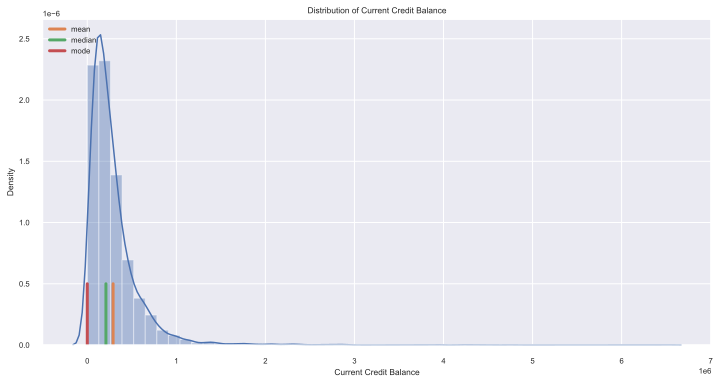

	Mean= 289833.24    Median= 209323.0    Mode= 0.0
	q025= 11970.00  	q005= 0.00
	q975= 1001579.77  	q995= 2058456.01


In [54]:
f_plot_distribution(train_df, 'Current Credit Balance')

In [55]:
crn_balance_boundaries = find_outer_boundaries(crn_balance)
crn_balance_boundaries

{'upper_bound': 1098855.5, 'lower_bound': -624192.75, 'iqr': 246149.75}

In [56]:
# судя по данным, которые больше остальных коррелируют с этим признаком, можно предположить, что каких-то аномалий нет
crn_balance_mask = crn_balance > crn_balance_boundaries['upper_bound']
train_df.loc[crn_balance_mask, ['Current Credit Balance', 'Annual Income', 'Monthly Debt']]

,Current Credit Balance,Annual Income,Monthly Debt
14,"1,374,327.000","2,258,796.000","58,352.000"
93,"2,327,443.000",NaN,"55,716.000"
162,"3,547,262.000","2,131,591.000","20,783.000"
391,"1,401,668.000","2,138,906.000","37,075.000"
561,"1,754,308.000","1,709,829.000","35,764.000"
...,...,...,...
7354,"1,160,444.000","1,334,066.000","31,573.000"
7377,"1,673,558.000","1,844,292.000","12,833.000"
7404,"1,157,385.000",NaN,"42,990.000"
7459,"1,149,614.000",NaN,"85,030.000"


#### Monthly Debt

In [57]:
# выбросов не наблюдается
debt = train_df['Monthly Debt']
debt.describe()

count     7,500.000
mean     18,314.454
std      11,926.765
min           0.000
25%      10,067.500
50%      16,076.500
75%      23,818.000
max     136,679.000
Name: Monthly Debt, dtype: float64

#### Credit Score

In [58]:
feature_name = 'Credit Score'
train_df[feature_name].describe()

count   5,943.000
mean    1,151.087
std     1,604.451
min       585.000
25%       711.000
50%       731.000
75%       743.000
max     7,510.000
Name: Credit Score, dtype: float64

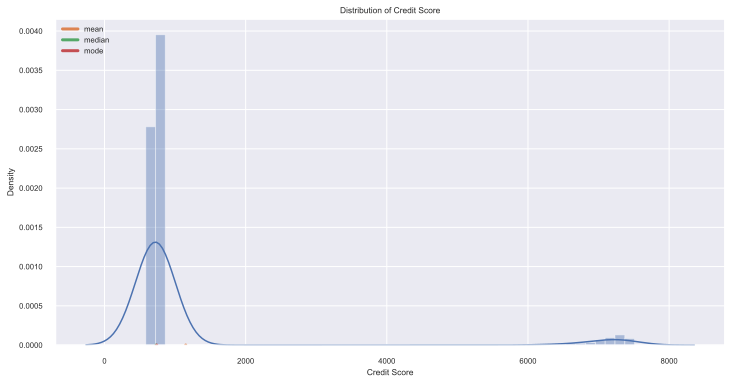

	Mean= 1151.09    Median= 731.0    Mode= 740.0
	q025= 648.00  	q005= 611.71
	q975= 7290.00  	q995= 7440.00


In [59]:
f_plot_distribution(train_df, 'Credit Score')

In [60]:
# Основные значения находятся в интервале от 0 до 1500, свыше - скорее всего выбросы.
score_mask = train_df[feature_name] > 1500
train_df.loc[score_mask, 'Credit Score']

69     6,470.000
87     7,440.000
94     7,010.000
96     7,320.000
116    7,390.000
          ...   
7422   6,690.000
7433   6,060.000
7450   7,290.000
7460   7,470.000
7496   7,410.000
Name: Credit Score, Length: 400, dtype: float64

In [61]:
# Вероятно допущена ошибка при вводе данных - дописан лишний 0 в конце. Скорректируем
cor_mask = (train_df[feature_name] > 1500) & (train_df[feature_name] % 10 == 0)
train_df.loc[cor_mask, 'Credit Score'] = train_df.loc[score_mask, 'Credit Score'] / 10
train_df.loc[train_df[feature_name] > 1500, 'Credit Score']

Series([], Name: Credit Score, dtype: float64)

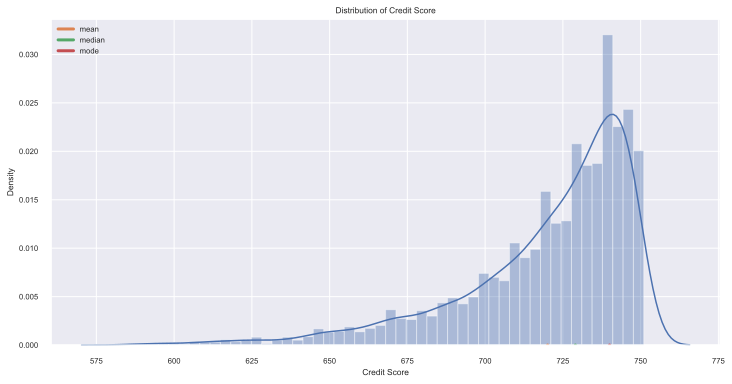

	Mean= 720.09    Median= 729.0    Mode= 740.0
	q025= 646.00  	q005= 611.00
	q975= 750.00  	q995= 751.00


In [62]:
f_plot_distribution(train_df, feature_name)

### <font color='red'>Обработка пропусков</font>

In [63]:
find_null_values(train_df)

Annual Income ~ 21%
Years in current job ~ 5%
Months since last delinquent ~ 54%
Bankruptcies ~ 0%
Credit Score ~ 21%


#### Annual Income

In [64]:
train_df['Annual Income'].fillna(ai_median, inplace = True)

#### Years in current job

In [65]:
feature_name = 'Years in current job'
train_df[feature_name].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

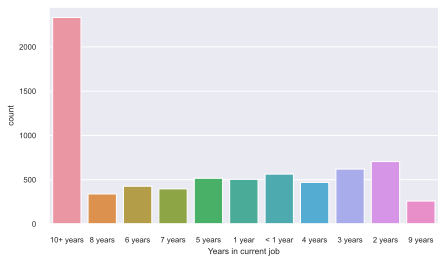

In [66]:
plt.figure(figsize=(7, 4))

sns.countplot(x='Years in current job', data=train_df)

plt.show()

In [67]:
train_df[feature_name].isna().sum()

371

In [68]:
# заполним пропуски модой
cjy_mode = train_df[feature_name].mode().loc[0]
train_df[feature_name].fillna(cjy_mode, inplace=True)
train_df[feature_name].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### Months since last delinquent

In [69]:
delinquent = train_df['Months since last delinquent']
delinquent.describe()

count   3,419.000
mean       34.693
std        21.689
min         0.000
25%        16.000
50%        32.000
75%        50.000
max       118.000
Name: Months since last delinquent, dtype: float64

32.0


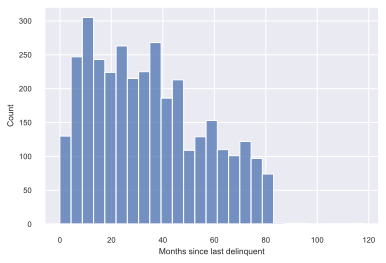

In [70]:
sns.histplot(data=train_df, x='Months since last delinquent')

print(delinquent.median())

plt.show()

In [71]:
# не увидел сильных корреляций с другими переменными, поэтому, пока заполнил пропуски нулями
train_df.loc[delinquent.isnull(), 'Months since last delinquent'] = 0
# no_delinquent = delinquent.isna() & (train_df['Tax Liens'] == 0)
# is_delinquent = delinquent.isna() & (train_df['Tax Liens'] > 0)

# train_df.loc[is_delinquent, 'Months since last delinquent'] = delinquent.median()
# train_df.loc[no_delinquent, 'Months since last delinquent'] = 0

In [72]:
# delinquent.value_counts()
delinquent.describe()

count   7,500.000
mean       15.815
std        22.649
min         0.000
25%         0.000
50%         0.000
75%        29.000
max       118.000
Name: Months since last delinquent, dtype: float64

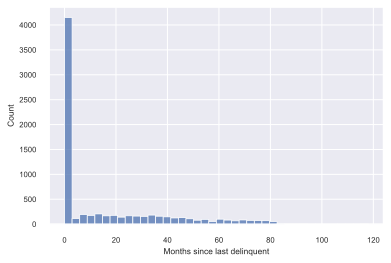

In [73]:
sns.histplot(data=train_df, x='Months since last delinquent')

plt.show()

#### Bankruptcies

In [74]:
bankrupt = train_df['Bankruptcies']
bankrupt.value_counts()

0.000    6660
1.000     786
2.000      31
3.000       7
4.000       2
Name: Bankruptcies, dtype: int64

In [75]:
# сильно коррелирует с 'Number of Credit Problems'
# заменим пропуски 0, там где нет проблем с кредитом, в остальных случаях - меняем на 1
not_bankrupt = bankrupt.isnull() & (train_df['Number of Credit Problems'] == 0)
is_bankrupt = bankrupt.isnull() & (train_df['Number of Credit Problems'] > 0)

train_df.loc[not_bankrupt, 'Bankruptcies'] = 0
train_df.loc[is_bankrupt, 'Bankruptcies'] = 1

# далее приведём к бинарному виду
train_df.loc[bankrupt > 0, 'Bankruptcies'] = 1

In [76]:
bankrupt.value_counts()

0.000    6674
1.000     826
Name: Bankruptcies, dtype: int64

#### Credit Score

In [77]:
# заменим пропуски медианой
train_df.loc[train_df['Credit Score'].isnull(), 'Credit Score'] = train_df['Credit Score'].median()
train_df['Credit Score']

0      749.000
1      737.000
2      742.000
3      694.000
4      719.000
         ...  
7495   697.000
7496   741.000
7497   748.000
7498   729.000
7499   729.000
Name: Credit Score, Length: 7500, dtype: float64

### <font color='red'>Создание новых признаков</font>

#### Tax Liens

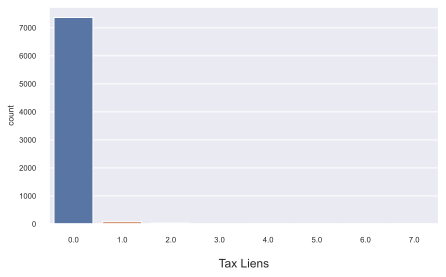

In [78]:
tax_liens = train_df['Tax Liens']

plt.figure(figsize=(7, 4))

sns.countplot(x='Tax Liens', data=train_df)

plt.xlabel('Tax Liens', fontsize=12, labelpad=15)
plt.show()

In [79]:
# бинарный признак
train_df['is_tax_liens'] = np.where(tax_liens > 0, 1, 0)
train_df['is_tax_liens'].value_counts()

0    7366
1     134
Name: is_tax_liens, dtype: int64

#### Number of Credit Problems

In [80]:
credit_problems = train_df['Number of Credit Problems']
credit_problems.value_counts()

0.000    6469
1.000     882
2.000      93
3.000      35
4.000       9
5.000       7
6.000       4
7.000       1
Name: Number of Credit Problems, dtype: int64

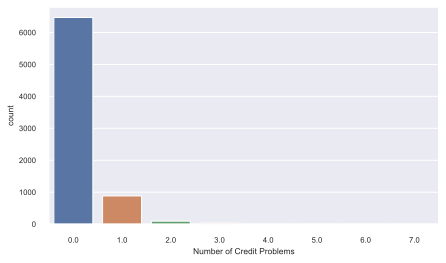

In [81]:
plt.figure(figsize=(7,4))

sns.countplot(x='Number of Credit Problems', data=train_df)

plt.show()

In [82]:
# бинарный признак
train_df['is_problem'] = np.where(credit_problems > 0, 1, 0)
train_df['is_problem'].value_counts()

0    6469
1    1031
Name: is_problem, dtype: int64

#### Term

In [83]:
# 'Long Term': Short Term - 0, Long Term - 1
train_df['Long Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})
train_df['Long Term'].value_counts()

0    5556
1    1944
Name: Long Term, dtype: int64

#### Соотношение ежемесячного платежа к доходу

In [84]:
train_df['monthly_debt_to_annual_income'] = train_df['Monthly Debt'] / train_df['Annual Income']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Home Ownership                 7500 non-null   object 
 1   Annual Income                  7500 non-null   float64
 2   Years in current job           7500 non-null   object 
 3   Tax Liens                      7500 non-null   float64
 4   Number of Open Accounts        7500 non-null   float64
 5   Years of Credit History        7500 non-null   float64
 6   Maximum Open Credit            7500 non-null   float64
 7   Number of Credit Problems      7500 non-null   float64
 8   Months since last delinquent   7500 non-null   float64
 9   Bankruptcies                   7500 non-null   float64
 10  Purpose                        7500 non-null   int64  
 11  Term                           7500 non-null   object 
 12  Current Loan Amount            7500 non-null   f